In [1]:
import os
import itertools
import random

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler

import numpy as np
from scipy.stats import *
import pandas as pd
import seaborn as sns
import pyro as pyro

from arspy import ars
from math import gamma

In [2]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':14})
rc('text', usetex=True)
plt.rc('axes', prop_cycle=(cycler('color', ['red', 'gray', 'black'])))#, 'blue', 'green'])))

# Gumbel distribution
$Y_i$ is the time-to-event for individual i, and we consider that $log(Y_i)$ follows a Gumbell distribution with the form:

$$ E(log Y_i|\mu, \beta, \delta, \alpha) = \mu + x'_i\beta +z'_i\delta $$
$$ Var(log Y_i|\mu, \beta, \delta, \alpha) = \frac{\pi}{6\alpha^2}$$

We have that 
- $\mu$: average scale for time-to-time event (intercept)
- $\beta$: SNP effect
- $\delta$: covariate effect
- $\alpha$: shape parameter of the distribution
- $x, z$: vectors of markers and covariates

_I dont know the difference between x, z and x', z'._

The Gumbel distribution looks like this for scale parameter 0 and shape parameter 0.1

In [3]:
mu, beta = 0, 0.1 # location and scale
s = np.random.gumbel(mu, beta, 1000)

In [4]:
def gumbel_distribution(x,b,a):
    return np.exp(-(x-b)/a)*np.exp(-np.exp(-(x-b)/a))/a

''

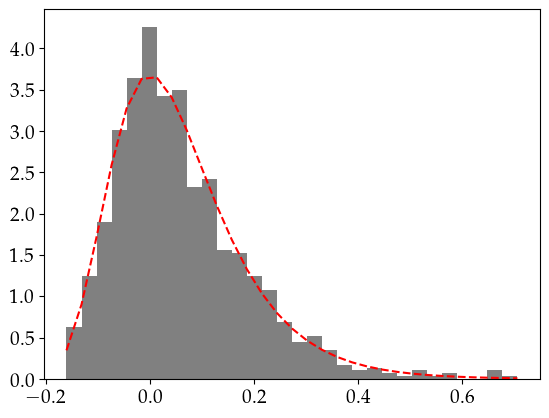

In [5]:
b = 0
a = 0.1
count, bins, ignored = plt.hist(s, 30, density=True, color = 'gray')
plt.plot(bins, gumbel_distribution(bins, 0,0.1), '--')
;

In [6]:
def scale_parameter(mu, beta, delta, markers, cov, shape_par):
    return np.exp(mu + np.dot(markers, beta) + np.dot(cov, delta) +(np.euler_gamma/shape_par))

We want to simulate a sample of one individual, with 100 markers and 10 covariates, where the effects are drawn from a normal distribution and the variables from a binomial distribution with probability 0.5. The shape parameter $\alpha$ is initialize to 0.1 and the average of the population is 10. 

In [10]:
size = 100
mu = 10
markers = np.random.binomial(2, 0.5, size)
cov = np.random.binomial(1, 0.5, size)
beta = np.random.normal(size=size)
delta=np.random.normal(size=size)
shape_par = 0.1

scale_par = scale_parameter(mu, beta, delta, markers, cov, shape_par)

In [11]:
shape_par, scale_par

(0.1, 28345977454.379044)

''

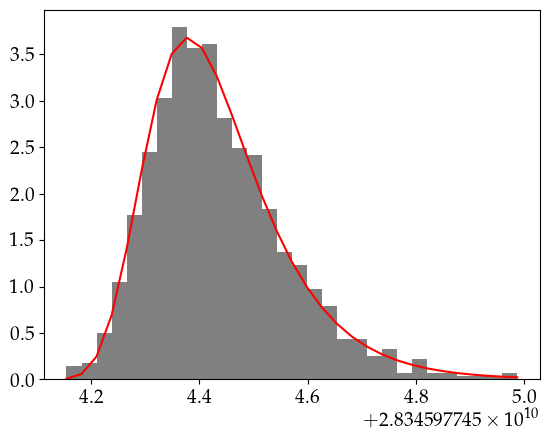

In [12]:
s = np.random.gumbel(scale_par, shape_par, 1000)
count, bins, ignored = plt.hist(s, 30, density=True, color = 'gray')
plt.plot(bins, gumbel_distribution(bins, scale_par, shape_par))
;

# Algorithm 1
Serial algorithm for BayesW sampling from the posterior distribution $p(\mu, \alpha, \delta, \gamma, \beta, \pi, \sigma_G^2|D)$ .Initialisation and prior speciﬁcation.

__Data__: 
- matrix $x$ of standardised genotypes, size M
- matrix with covariate data $z$, size C
- vector of last time without an event $y$ size L
- vector of failure indicators $d$
- prior hyperparameters , $p_L$ size P:
    - $\alpha_0, \kappa_0$: parameters of the prior distribution of $\alpha$, gamma distribution
    $$ p(\alpha) \propto \alpha^{\alpha_0 -1} \exp(-\kappa_0\alpha)$$
    - $\alpha_{\sigma}, \beta_{\sigma}$: parameters of the $\sigma_G^2$
    - $\sigma^2_{\mu}$: variance parameter of the prior distribution of $\mu$ 
    - $\sigma^2_{\delta}$: variance parameter of the prior distribution of $\delta$
- iterations $I$
- $V_0 , V_1 and V_2$ denote the partial sums of the exponentiated residuals
(deﬁned in Derivations for the sparse calculations)
- K is the Euler-Mascheroni constant.

__Initial values__: Initially, we exclude all the variables from the model.
- $y_j =0 \forall j \in {1,...,M}$. 
- $\beta_j =0 \forall j$ 
- $\sigma_q = 0 \forall q$ 
- $\alpha$: suitably transformed variance of the log sample. 
- $\mu$: mean of the log sample. 
- $\sigma_G^2$: the variance of the log sample divided by the total number of markers M.

__Parameters for prior distributions__: We set priors weakly informative. Otherwise, if
available, prior information could be used. 
- $\alpha$: $\alpha_0 = 0.01, \kappa_0 = 0.01$
- $\sigma^2_G$: $\alpha_{\sigma}=1$ and $\beta_{\sigma} = 0.0001$.
- $\mu$: $\sigma^2_{\mu} = 100$ 
- $\delta_q$:$\sigma^2_{\delta} = 100$
- $\pi$ and $p_L$: vector of ones

## Prior distributions
 prior hyperparameters , $p_L$:
    - $\alpha_0, \kappa_0$: parameters of the prior distribution of $\alpha$, gamma distribution
    $$ p(\alpha) \propto \alpha^{\alpha_0 -1} \exp(-\kappa_0\alpha)$$
    - $\alpha_{\sigma}, \beta_{\sigma}$: parameters of the $\sigma_G^2$
    - $\sigma^2_{\mu}$: variance parameter of the prior distribution of $\mu$ 
    - $\sigma^2_{\delta}$: variance parameter of the prior distribution of $\delta$

Prior distribution of $\alpha$: gamma distribution with parameters $\alpha_0, \kappa_0$.

$$ p(\alpha) \propto \alpha^{\alpha_0 -1} \exp(-\kappa_0\alpha)$$

Prior for $\beta_j$ follow a normal distribution with variance parameter $\sigma^2_G$

$$p(\beta_j|\sigma^2_G, y_j=k) \propto \left(\frac{1}{C_k\sigma_G^2}\right)^2 \exp(-\frac{1}{2C_k\sigma_G^2}\beta_j^2)$$

Prior of $\sigma^2_G$ follow a inverse gamma distribution with parameters $\alpha_{\sigma}, \beta_{\sigma}$

$$p(\sigma^2_G)\propto \left(\frac{1}{\sigma^2_G}\right)^{\alpha_{\sigma} +1}\exp\left(-\frac{\beta_{\sigma}}{\alpha_{\sigma}}\right)$$ 

Prior of $\delta_q$ (effect of the covariate q) is a normal with variance $\sigma^2_{\delta}$:

$$p(\delta_q\propto  \exp\left(-\frac{1}{2\sigma^2_{\delta}}\delta_q^2\right)$$

Prior of $\mu$ is a normal distribution with variance $\sigma^2_{\mu}$

$$p(\mu\propto  \exp\left(-\frac{1}{2\sigma^2_{\mu}}\mu^2\right)$$

The prior for $y_j$ is a multinomial distribution

$$p(y_j|\pi)\propto = \pi_0^{I(y_j=0)}\cdot...\cdot \pi_L^{I(y_j=L)}$$

The prior probabilities of belonging to each of the mixture distributions k are stored in L+1 dimensional vector $\bf\pi$ with the prior for $\bf\pi$ a Dirichlet distribution

$$ p(\pi) \propto Dirichlet(p_L)$$

where $I(\cdot)$ is the indicator function and $p_L$ is the L+1 dimensional vector with prior values. 




In [10]:
#data
n_markers = 100 #number M of markers
n_samples = 100 #number of individuals (times to event)
n_covs = 10 #number of covariates
l_mix = 4 #mixture components
max_iter = 1000

#simulated data
markers = np.random.binomial(2, 0.5, size = (n_samples, n_markers)) #x matrix of markers
cov = np.random.binomial(1, 0.5, size = (n_samples, n_covs)) #z matrix of 
y_data = np.random.choice(range(1,50), 100,)
d_fail = np.random.choice(range(1,50), 100,)

Having the matrix M of genotypes then we can calculate the partial sums for each genotype

Initial values for the parameters:
- mu is the intercept (time to event) $\mu$
- betas are the effects of the markers $\beta_j$ for j marker
- deltas are the effects of the covariates $\delta_q$ for q covariate
- gammas are the mixture indicators of the markers $\gamma_j$ for j marker

In [11]:
#initial values
betas = np.zeros(n_markers)
deltas = np.zeros(n_covs)
gammas = np.zeros(n_markers)
mu = np.mean(np.log(y_data))
sigma_g = np.var(np.log(y_data))/n_markers


We define the parameters for the priors of the parameters

In [12]:
#priors of parameters
alpha_zero = 0.01
kappa_zero = 0.01
alpha_sigma = 1
beta_sigma = 0.0001
var_mu = 100
var_delta = 100
pi_vector = np.zeros(l_mix) + 1
hyperparameters = np.zeros(l_mix +1)


In [13]:
def univariate_normal(x, mean=0, variance=var_mu):
    """pdf of the univariate normal distribution."""
    return ((1. / np.sqrt(2 * np.pi * variance)) * 
            np.exp(-(x - mean)**2 / (2 * variance)))

In [14]:
def normal_to_lognormal(mu, var):
    """
    Convert parameters of a normal distribution to parameters of a lognormal distribution.

    Parameters:
        mu (float): Mean of the normal distribution.
        var(float): var of the normal distribution.

    Returns:
        A tuple (lognormal_mu, lognormal_var) containing the mean and standard deviation of the corresponding lognormal distribution.
    """
    lognormal_mu = np.exp(mu + var/2)
    lognormal_var = np.exp(2*var)*(np.exp(var)-1)*np.exp(2*mu)
    return lognormal_mu, lognormal_var

In [15]:
def lognormal(x, var_normal):
    args = normal_to_lognormal(0, np.sqrt(var_normal))
    var = args[1]**2
    mean = args[0]
    return((1. /x*np.sqrt(2*np.pi*var))*np.exp(-(np.log(x)-mean)**2/(2*var)))

In [16]:
def gaussian_logpdf(x, args=normal_to_lognormal(0, var_mu)):
    return (1/(x*np.sqrt(2*np.pi*args[1])))*np.exp(-((np.log(x)-args[0])**2)/(2*args[1]))

In [17]:
import ars as ars

In [18]:
log_prob = ars.log_gaussian(0, 100)

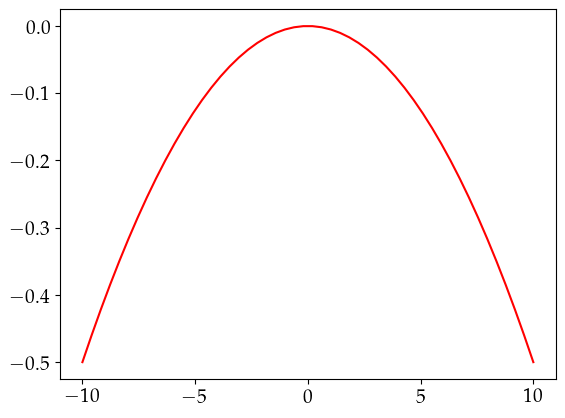

In [19]:
x = np.linspace(-10,10)
plt.plot(x, log_prob(x)[0])

In [20]:
target_mean = 0.
target_variance = 100.

x0 = 0.95*mu
num_samples = 1
lims = (0.8*mu, 1.1*mu)
log_unnorm_prob = ars.log_gaussian(mean=target_mean, variance=target_variance)

In [21]:
ars.adaptive_rejection_sampling(x0, log_unnorm_prob, num_samples, lims)

ValueError: probabilities are not non-negative

In [ ]:
#gaussian_logpdf = lambda x, sigma=args[1]: np.log(np.exp(-x ** 2 / sigma))
a, b = 2,5  # a < b must hold
domain = (float(0), float("inf"))
n_samples = 10000
samples = ars.adaptive_rejection_sampling(logpdf=gaussian_logpdf, a=a, b=b, domain=domain, n_samples=n_samples)

In [ ]:
def inverse_gamma_dist(x, alpha, beta):
    """pdf of gamma distribution with parameters alpha and beta"""
    return ((beta**alpha/gamma(alpha))*((1/x)**(alpha + 1))*np.exp(-beta/x))

First we define the array of errors of length N (number of individuals) as 

$$\epsilon_i = y_i -\mu$$

So we substract the sample mean (defined as the mean of the log sample) to each of the data components (time to event for each individual)

_Are the time to event data points in log or normal scale? Because we are substracting the log of the mean, and the Gumbel distribution takes the log of Y_

In [ ]:
residuals = y_data - mu

We do the following process for every iteration

In [ ]:
def lognormal_mu(x, sigma=var_mu):
        return np.log(np.exp(-x ** 2 / sigma))

fist we sample the intercept

In [ ]:
var_mu = 100

In [ ]:
old_residuals = residuals

residuals = old_residuals + mu

domain = (float(0), float("inf"))
n_samples = 1000
samples = ars.adaptive_rejection_sampling(logpdf=lognormal_mu, a=2, b=5, domain=domain, n_samples=n_samples)
mu = np.mean(samples)
residuals = residuals - mu




In [ ]:
plt.hist(samples, density=True, bins=100)
;

sample of delta for each covariate

In [ ]:
def lognormal_delta(x, sigma=var_delta):
    return np.log(np.exp(-x ** 2 / sigma))

In [ ]:
residuals = residuals + cov[:,0]*deltas[0]
samples = ars.adaptive_rejection_sampling(logpdf=lognormal_delta, a=2, b=5, domain=domain, n_samples=n_samples)


In [ ]:
plt.hist(samples, density=True, bins=100)
;